## Import libraries and init

In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
import seaborn as sns
import math

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

## Load ntuples from analyzer

In [3]:
masses = [('60','20'),('52p5','5p0'),('6p0','2p0'),('5p25','0p5')]
mchis = ['60', '52p5', '6p0', '5p25']
ctaus = [1, 10, 100, 1000]

branchFolder = 'RECO_dsa'
# baseDir = '../Firefighter/washAOD/trigger2018Studies/'
baseDir = '../Firefighter/washAOD/trigger2017Studies/'
fileName = lambda Mchi, dMchi, ctau: baseDir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

numParams = len(masses)*len(ctaus)
count = 1

recoDfs = OrderedDict({})
genDfs = OrderedDict({})
for (Mchi, dMchi) in masses:
    recoDfs[Mchi] = OrderedDict({})
    genDfs[Mchi] = OrderedDict({})
    for ctau in ctaus:
#         recoDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['RECO_dsa' + '/recoEffiForMuTrack'].pandas.df()
        recoDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['TRIGself_dsa_HLT_PFMET120_PFMHT120' + '/trigSelfEffiForMuTrack'].pandas.df()
        genDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN' + '/gen'].pandas.df()
        print(f'{count} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
        count += 1

1 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-60_dMchi-20_ctau-1.root
2 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-60_dMchi-20_ctau-10.root
3 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-60_dMchi-20_ctau-100.root
4 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-60_dMchi-20_ctau-1000.root
5 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-52p5_dMchi-5p0_ctau-1.root
6 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-52p5_dMchi-5p0_ctau-10.root
7 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-52p5_dMchi-5p0_ctau-100.root
8 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-52p5_dMchi-5p0_ctau-1000.root
9 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-6p0_dMchi-2p0_ctau-1.root
10 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-6p0_dMchi-2p0_ctau-10.root
11 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-6p0_dMchi-2p0_ctau-100.root
12 of 16: ../Firefighter/washAOD/trigger2017Studies/Mchi-6p0_dMchi-2p0_ctau-1000.root

## Muon pT plots

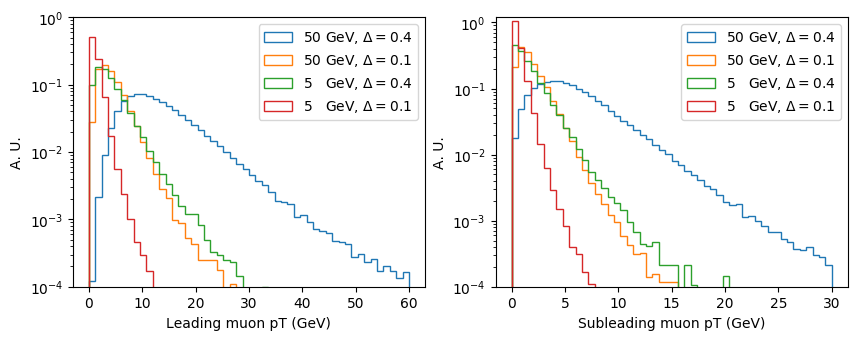

In [100]:
labels = {'60':'50 GeV, $\Delta=0.4$', '52p5':'50 GeV, $\Delta=0.1$', \
         '6p0':'5   GeV, $\Delta=0.4$', '5p25':'5   GeV, $\Delta=0.1$'}

fig, ax = plt.subplots(1,2, figsize=(10,3.5))

for mchi in mchis:
    leadingMuPt = genNewDfs[mchi][10].query('pid==13|pid==-13').groupby('entry')['pt'].max()
    ax[0].hist(leadingMuPt, bins=50, range=(0,60), histtype='step', density=True, log=True, label=labels[mchi]);
ax[0].set_ylim([0.0001, 1])
ax[0].set_xlabel('Leading muon pT (GeV)')
ax[0].set_ylabel('A. U.')
ax[0].legend();

for mchi in mchis:
    subleadingMuPt = genNewDfs[mchi][10].query('pid==13|pid==-13').groupby('entry')['pt'].min()
    ax[1].hist(subleadingMuPt, bins=50, range=(0,30), histtype='step', density=True, log=True, label=labels[mchi]);
ax[1].set_ylim([0.0001, 1.2])
ax[1].set_xlabel('Subleading muon pT (GeV)')
ax[1].set_ylabel('A. U.')
ax[1].legend();


## Muon phi and dR plots

In [28]:
# Helper function to normalize angle differences to [-Pi, Pi]
# cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
def reducephi(row):
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

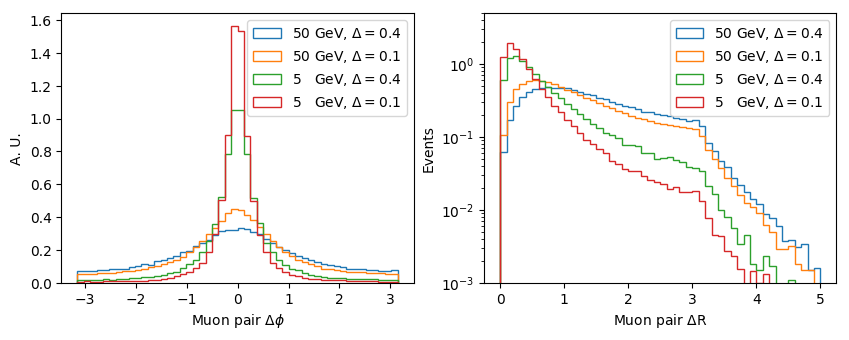

In [175]:
# plt.figure(figsize=(5,3.5))
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

for mchi in mchis:
    reducedGenDf = genNewDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    phidiff = reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2']
#     phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
#         abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
    reducedphidiff = phidiff.apply(reducephi)
    ax[0].hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi], log=False);

ax[0].set_xlabel('Muon pair $\Delta\phi$')
ax[0].set_ylabel('A. U.')
ax[0].legend();

for mchi in mchis:
    reducedGenDf = genNewDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
        abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
    deltaR = np.sqrt((reducedGenDf['eta']['mu1'] - reducedGenDf['eta']['mu2'])**2 + (phidiff)**2)
    ax[1].hist(deltaR, bins=50, range=(0,5), density=True, log=True, histtype='step', label=labels[mchi]);

ax[1].set_xlabel('Muon pair $\Delta$R')
ax[1].set_ylabel('Events')
ax[1].set_ylim(0.001, 5)
ax[1].legend();

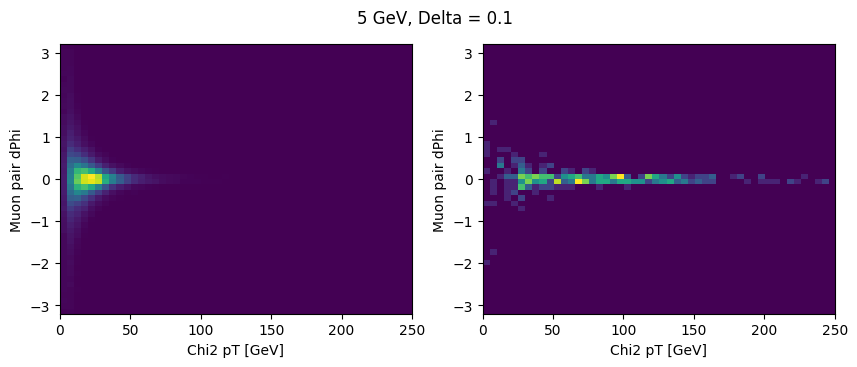

In [189]:
mchi = '5p25'
fig, axes = plt.subplots(1,2, figsize=(10,3.5))

trigEvents = recoDfs[mchi][10].query('subentry==0').reset_index()['entry']
trigCriteria = genDfs[mchi][10].query('subentry==0').reset_index()['entry'].isin(trigEvents)
chi2pTs = genDfs[mchi][10].query('pid==1000023').reset_index().loc[ trigCriteria ][['pt']]

reducedGenDf = genDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
phidiff = reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2']
#     phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
#         abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
reducedphidiff = phidiff.apply(reducephi)
reducedphidiff.reset_index()
chi2pTs['mudPhi'] = reducedphidiff
axes[0].hist2d(chi2pTs.dropna()['pt'], chi2pTs.dropna()['mudPhi'], bins=(50,50), range=((0,250),(-3.2,3.2)));
axes[0].set_xlabel('Chi2 pT [GeV]')
axes[0].set_ylabel('Muon pair dPhi');

trigEvents = recoDfs[mchi][10].query('subentry==0&fired==True').reset_index()['entry']
trigCriteria = genDfs[mchi][10].query('subentry==0').reset_index()['entry'].isin(trigEvents)
chi2pTs = genDfs[mchi][10].query('pid==1000023').reset_index().loc[ trigCriteria ][['pt']]

reducedGenDf = genDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
phidiff = reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2']
#     phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
#         abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
reducedphidiff = phidiff.apply(reducephi)
reducedphidiff.reset_index()
chi2pTs['mudPhi'] = reducedphidiff
axes[1].hist2d(chi2pTs.dropna()['pt'], chi2pTs.dropna()['mudPhi'], bins=(50,50), range=((0,250),(-3.2,3.2)));
axes[1].set_xlabel('Chi2 pT [GeV]')
axes[1].set_ylabel('Muon pair dPhi');
fig.suptitle('5 GeV, Delta = 0.1');


# plt.hist(reducedphidiff,bins=50,histtype='step',density=True, label='All')
# plt.xlabel('Muon pair dPhi')
# plt.ylabel('A. U.')
# plt.hist(chi2pTs.dropna()['mudPhi'],bins=50,histtype='step',density=True,label='Triggered');
# plt.legend();
# plt.title('5 GeV, Delta = 0.1');

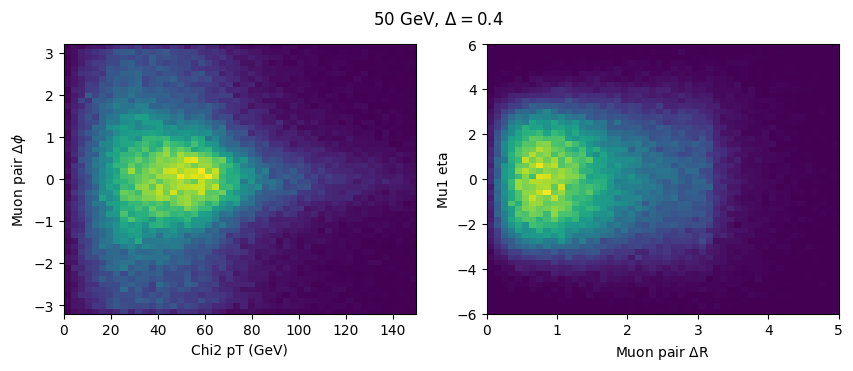

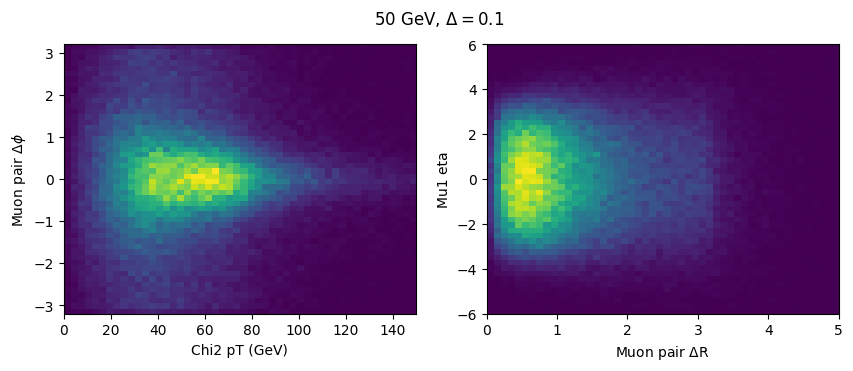

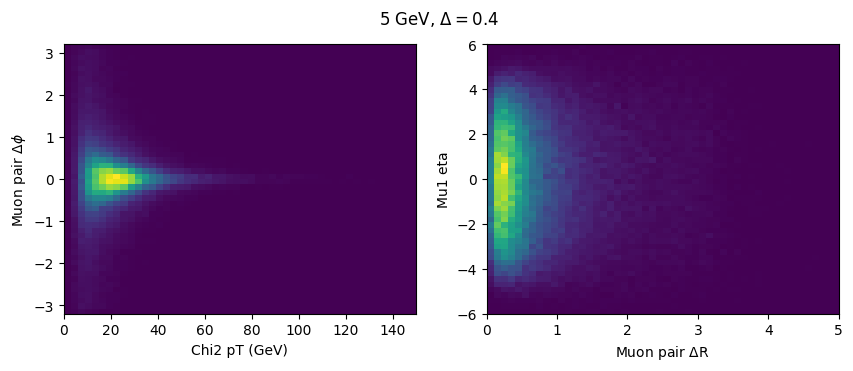

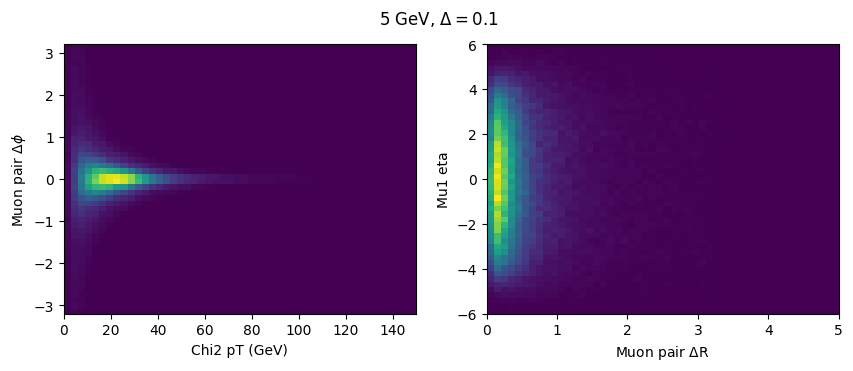

In [240]:
for mchi in mchis:
    fig, ax = plt.subplots(1,2, figsize=(10,3.5))
    fig.suptitle(' '.join(labels[mchi].split()))
    reducedGenDf = genNewDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    phidiff = reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2']
    #     phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
    #         abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
    reducedphidiff = phidiff.apply(reducephi)
    
    ax[0].hist2d(genNewDfs[mchi][10].loc[(slice(None), 2), :]['pt'], reducedphidiff, bins=(50,50), range=((0,150),(-3.2,3.2)));
    ax[0].set_ylabel('Muon pair $\Delta\phi$')
    ax[0].set_xlabel('Chi2 pT (GeV)')

    reducedGenDf = genNewDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    phidiff = pd.concat([abs((math.pi - abs(reducedGenDf['phi']['mu1'])) + (math.pi - abs(reducedGenDf['phi','mu2']))), \
        abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1).min(axis=1)
    deltaR = np.sqrt((reducedGenDf['eta']['mu1'] - reducedGenDf['eta']['mu2'])**2 + (phidiff)**2)
    
    ax[1].hist2d(deltaR, reducedGenDf['eta']['mu1'], label=labels[mchi], alpha=1.0, bins=(50,50), range=((0,5),(-6,6)))    
    ax[1].set_xlabel('Muon pair $\Delta$R')
    ax[1].set_ylabel('Mu1 eta')

## Muon eta distributions

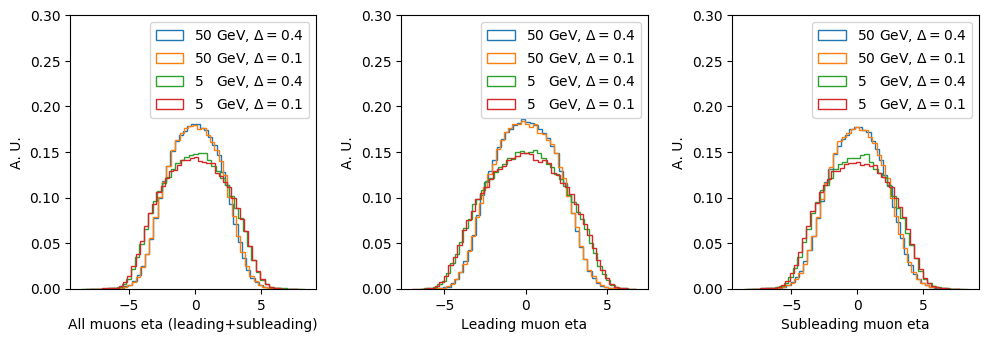

In [220]:
fig, ax = plt.subplots(1,3, figsize=(10,3.5))

for mchi in mchis:
    ax[0].hist(genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label=labels[mchi], histtype='step');

ax[0].set_xlabel('All muons eta (leading+subleading)')
ax[0].set_ylabel('A. U.')
ax[0].set_ylim(0, 0.3)
ax[0].legend();

for mchi in mchis:
    idx = genNewDfs[mchi][10].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genNewDfs[mchi][10].query('pid==13|pid==-13')['pt']
    leadingMu = genNewDfs[mchi][10].query('pid==13|pid==-13').loc[idx]
    subleadingMu = genNewDfs[mchi][10].query('pid==13|pid==-13').loc[~idx]
    ax[1].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label=labels[mchi])
    ax[2].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label=labels[mchi])


ax[1].set_xlabel('Leading muon eta')
ax[1].set_ylabel('A. U.')
ax[1].set_ylim(0, 0.3)
ax[1].legend();

ax[2].set_xlabel('Subleading muon eta')
ax[2].set_ylabel('A. U.')
ax[2].set_ylim(0, 0.3)
ax[2].legend();

plt.tight_layout(pad=1.0)

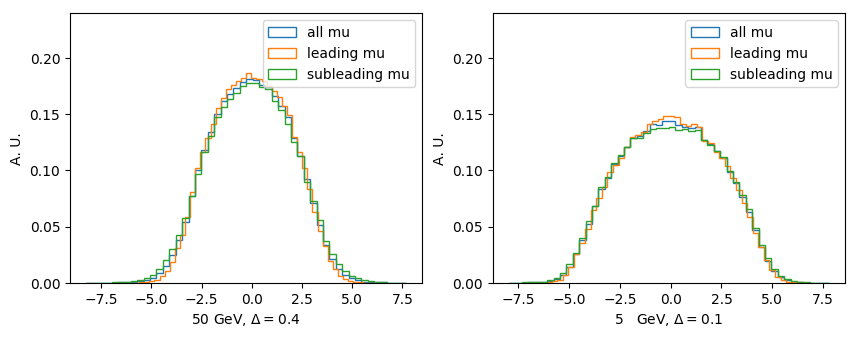

In [232]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

mchi = '60'

ax[0].hist(genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label='all mu', histtype='step');
idx = genNewDfs[mchi][10].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genNewDfs[mchi][10].query('pid==13|pid==-13')['pt']
leadingMu = genNewDfs[mchi][10].query('pid==13|pid==-13').loc[idx]
subleadingMu = genNewDfs[mchi][10].query('pid==13|pid==-13').loc[~idx]
ax[0].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label='leading mu');
ax[0].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label='subleading mu');

ax[0].set_xlabel(labels[mchi])
ax[0].set_ylabel('A. U.')
ax[0].set_ylim(0, 0.24)
ax[0].legend();

mchi = '5p25'

ax[1].hist(genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label='all mu', histtype='step');
idx = genNewDfs[mchi][10].query('pid==13|pid==-13').groupby('entry')['pt'].transform(max) ==  genNewDfs[mchi][10].query('pid==13|pid==-13')['pt']
leadingMu = genNewDfs[mchi][10].query('pid==13|pid==-13').loc[idx]
subleadingMu = genNewDfs[mchi][10].query('pid==13|pid==-13').loc[~idx]
ax[1].hist(leadingMu['eta'], bins=50, histtype='step', density=True, label='leading mu');
ax[1].hist(subleadingMu['eta'], bins=50, histtype='step', density=True, label='subleading mu');

ax[1].set_xlabel(labels[mchi])
ax[1].set_ylabel('A. U.')
ax[1].set_ylim(0, 0.24)
ax[1].legend();

## Muons eta vs pT

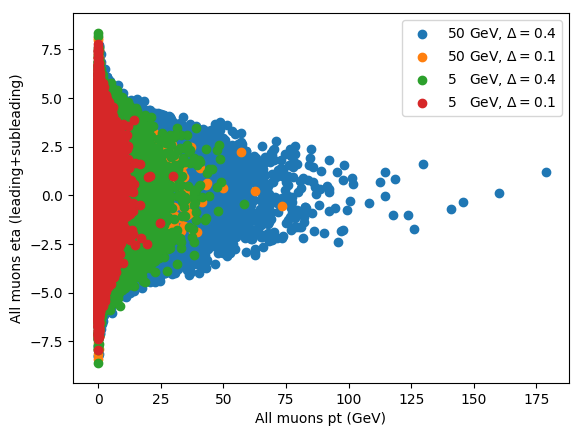

In [243]:
for mchi in mchis:
#     plt.hist(genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['eta'], bins=50, density=True, label=labels[mchi], histtype='step');
    plt.scatter(genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['pt'], genNewDfs[mchi][10].loc[(slice(None), [5,6]), :]['eta'], label=labels[mchi])
    plt.ylabel('All muons eta (leading+subleading)')
    plt.xlabel('All muons pt (GeV)')
plt.legend();

## Muon vxy and vz plots

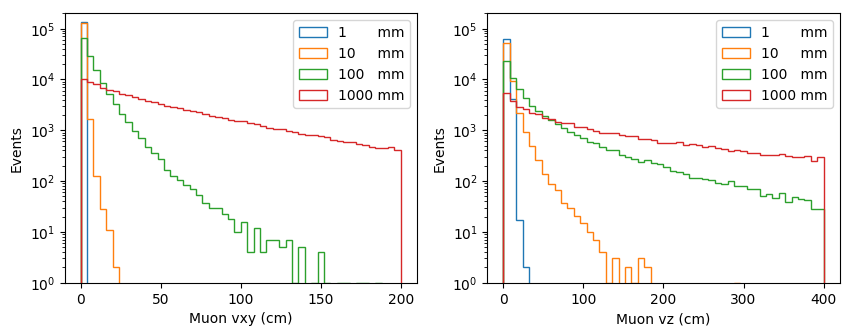

In [103]:
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

labels_ctau = {1:'1       mm', 10:'10     mm', 100:'100   mm', 1000:'1000 mm'}
# labels_ctau = {1:'1 mm', 10:'10 mm', 100:'100 mm', 1000:'1000 mm'}

for ctau in ctaus:
    vxy = genDfs['60'][ctau].query('(pid==13|pid==-13)&subentry==5')['vxy']
    ax[0].hist(vxy, bins=50, range=(0,200), histtype='step', density=False, log=True, label=labels_ctau[ctau]);
ax[0].set_ylim([1, 200000])
ax[0].set_xlabel('Muon vxy (cm)')
ax[0].set_ylabel('Events')
ax[0].legend();

for ctau in ctaus:
    vz = genDfs['60'][ctau].query('(pid==13|pid==-13)&subentry==5')['vz']
    ax[1].hist(vz, bins=50, range=(0,400), histtype='step', density=False, log=True, label=labels_ctau[ctau]);
ax[1].set_ylim([1, 200000])
ax[1].set_xlabel('Muon vz (cm)')
ax[1].set_ylabel('Events')
ax[1].legend();

## Load files with additional data (jet eta and phi, MET phi) to make relevant plots

In [3]:
masses = [('60','20'),('52p5','5p0'),('6p0','2p0'),('5p25','0p5')]
mchis = ['60', '52p5', '6p0', '5p25']
ctaus = [10]

branchFolder = 'RECO_dsa'
baseDir = '../Firefighter/washAOD/GenInfoStudies/'
fileName = lambda Mchi, dMchi, ctau: baseDir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

numParams = len(masses)*len(ctaus)
count = 1

recoNewDfs = OrderedDict({})
genNewDfs = OrderedDict({})
for (Mchi, dMchi) in masses:
    recoNewDfs[Mchi] = OrderedDict({})
    genNewDfs[Mchi] = OrderedDict({})
    for ctau in ctaus:
        recoNewDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['RECO_dsa' + '/recoEffiForMuTrack'].pandas.df()
        genNewDfs[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN' + '/gen'].pandas.df()
        print(f'{count} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
        count += 1

1 of 4: ../Firefighter/washAOD/GenInfoStudies/Mchi-60_dMchi-20_ctau-10.root
2 of 4: ../Firefighter/washAOD/GenInfoStudies/Mchi-52p5_dMchi-5p0_ctau-10.root
3 of 4: ../Firefighter/washAOD/GenInfoStudies/Mchi-6p0_dMchi-2p0_ctau-10.root
4 of 4: ../Firefighter/washAOD/GenInfoStudies/Mchi-5p25_dMchi-0p5_ctau-10.root


## Plot deltaPhi between jet and MET

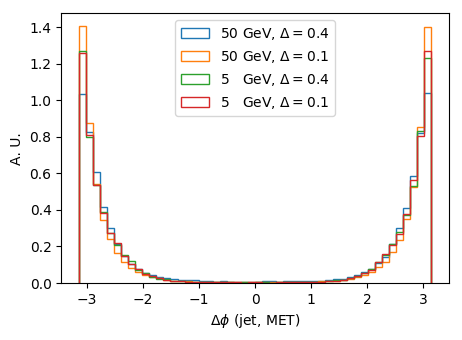

In [38]:
plt.figure(figsize=(5,3.5))

for mchi in mchis:
    reducedGenDf = genNewDfs[mchi][10].query('pid==13|pid==-13')[['eta','phi']].unstack(level=1)
    reducedGenDf.rename({5:'mu1',6:'mu2'}, axis='columns', inplace=True)
    phidiff = recoNewDfs[mchi][10]['genJetPhi'].dropna() - recoNewDfs[mchi][10]['genLeadMetPhi'].dropna()
    reducedphidiff = phidiff.apply(reducephi)
#     phidiff = pd.concat([abs((math.pi - abs(recoNewDfs[mchi][10]['genJetPhi'].dropna())) + (math.pi - abs(recoNewDfs[mchi][10]['genLeadMetPhi'].dropna()))), \
#         abs(recoNewDfs[mchi][10]['genJetPhi'].dropna() - recoNewDfs[mchi][10]['genLeadMetPhi'].dropna())], axis=1).min(axis=1)
    plt.hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi]);

plt.xlabel('$\Delta\phi$ (jet, MET)')
plt.ylabel('A. U.')
plt.legend(loc='upper center');

## Plot deltaPhi between MET and muon pair and between the 2 chi1 DM particles

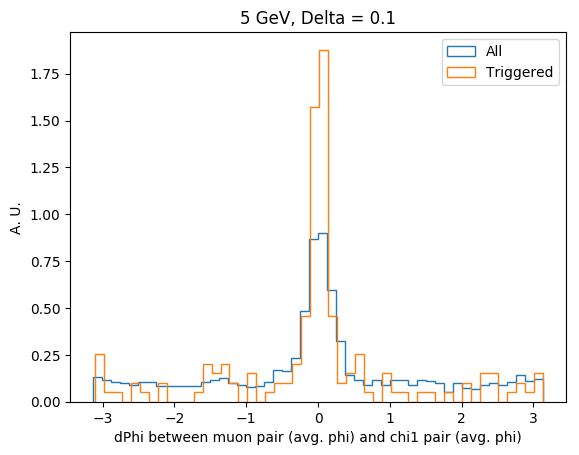

In [193]:
mchi='5p25'

crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
eventsWith2Mus = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) ]
phi1 = eventsWith2Mus.query('subentry==0')['phi'].reset_index()['phi']
phi2 = eventsWith2Mus.query('subentry==1')['phi'].reset_index()['phi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))

phichi1_1 = genDfs[mchi][10].query('subentry==3').reset_index()['phi']
phichi1_2 = genDfs[mchi][10].query('subentry==4').reset_index()['phi']
avgchi1Phi = pd.DataFrame(np.arctan2((np.sin(phichi1_1) + np.sin(phichi1_2)), (np.cos(phichi1_1) + np.cos(phichi1_2))))
finalchiavgphi=avgchi1Phi.reset_index().loc[ avgchi1Phi.reset_index()['index'].isin(eventsWith2Mus.query('subentry==1')['entry']) ].reset_index()['phi']
phidiff = avgPhi['phi'] - finalchiavgphi
reducedphi = phidiff.apply(reducephi)
plt.hist(reducedphi,bins=50,histtype='step', density=True, label='All');



trigEvents = recoDfs[mchi][10].query('subentry==0&fired==True').reset_index()['entry']

crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
eventsWith2MusAndTrig = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) \
                                                           & recoDfs[mchi][10].reset_index()['entry'].isin(trigEvents) ]
phi1 = eventsWith2MusAndTrig.query('subentry==0')['phi'].reset_index()['phi']
phi2 = eventsWith2MusAndTrig.query('subentry==1')['phi'].reset_index()['phi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))

phichi1_1 = genDfs[mchi][10].query('subentry==3').reset_index()['phi']
phichi1_2 = genDfs[mchi][10].query('subentry==4').reset_index()['phi']
avgchi1Phi = pd.DataFrame(np.arctan2((np.sin(phichi1_1) + np.sin(phichi1_2)), (np.cos(phichi1_1) + np.cos(phichi1_2))))
finalchiavgphi=avgchi1Phi.reset_index().loc[ avgchi1Phi.reset_index()['index'].isin(eventsWith2MusAndTrig.query('subentry==1')['entry']) ].reset_index()['phi']
phidiff = avgPhi['phi'] - finalchiavgphi
reducedphi = phidiff.apply(reducephi)
plt.hist(reducedphi,bins=50,histtype='step', density=True, label='Triggered');

plt.xlabel('dPhi between muon pair (avg. phi) and chi1 pair (avg. phi)')
plt.ylabel('A. U.')
plt.title('5 GeV, Delta = 0.1')
plt.legend();

In [155]:
crit2Mus = recoDfs[mchi][10].query('subentry==1').reset_index()['entry']
eventsWith2Mus = recoDfs[mchi][10].reset_index().loc[recoDfs[mchi][10].reset_index()['entry'].isin(crit2Mus) ]
phi1 = eventsWith2Mus.query('subentry==0')['phi'].reset_index()['phi']
phi2 = eventsWith2Mus.query('subentry==1')['phi'].reset_index()['phi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
# reducedDf = pd.concat([avgPhi, eventsWith2Mus.query('subentry==0')['genLeadMetPhi']], axis=1)
# phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
# reducedphidiff = phidiff.apply(reducephi)

In [ ]:
phi1 = recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genPhi']
phi2 = recoNewDfs[mchi][10].query('subentry==1').reset_index('subentry')['genPhi']
avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
reducedDf = pd.concat([avgPhi, recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genLeadMetPhi']], axis=1)
phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
reducedphidiff = phidiff.apply(reducephi)

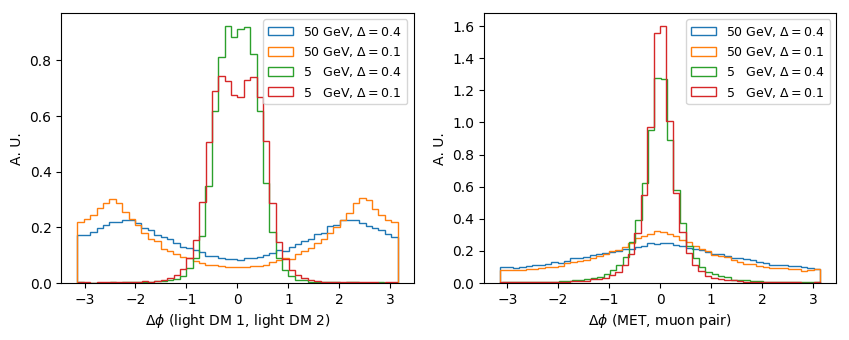

In [111]:
# plt.figure(figsize=(5,3.5))
fig, ax = plt.subplots(1,2, figsize=(10,3.5))

for mchi in mchis:
    phidiff = genNewDfs[mchi][10].query('subentry==3').reset_index('subentry')['phi'] - \
                genNewDfs[mchi][10].query('subentry==4').reset_index('subentry')['phi']
    reducedphidiff = phidiff.apply(reducephi)
    ax[0].hist(reducedphidiff, bins=50, density=True, histtype='step', label=labels[mchi])

ax[0].set_xlabel('$\Delta\phi$ (light DM 1, light DM 2)')
ax[0].set_ylabel('A. U.')
ax[0].legend(prop={'size': 9});

for mchi in mchis:
    phi1 = recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genPhi']
    phi2 = recoNewDfs[mchi][10].query('subentry==1').reset_index('subentry')['genPhi']
    avgPhi = pd.DataFrame(np.arctan2((np.sin(phi1) + np.sin(phi2)), (np.cos(phi1) + np.cos(phi2))))
    reducedDf = pd.concat([avgPhi, recoNewDfs[mchi][10].query('subentry==0').reset_index('subentry')['genLeadMetPhi']], axis=1)
    phidiff = reducedDf['genPhi'] - reducedDf['genLeadMetPhi']
    reducedphidiff = phidiff.apply(reducephi)
    ax[1].hist(reducedphidiff,bins=50, density=True, histtype='step', label=labels[mchi], log=False);

ax[1].set_xlabel('$\Delta\phi$ (MET, muon pair)')
ax[1].set_ylabel('A. U.')
ax[1].legend(prop={'size': 9});

# phidiff = pd.concat([abs(2*math.pi - abs(genNewDfs['60'][10].query('subentry==3').reset_index('subentry')['phi']) - abs(genNewDfs['60'][10].query('subentry==4').reset_index('subentry')['phi'])), \
#         abs(genNewDfs['60'][10].query('subentry==3').reset_index('subentry')['phi'] - genNewDfs['60'][10].query('subentry==4').reset_index('subentry')['phi'])], axis=1).min(axis=1)

## Di-muon invariant mass plot

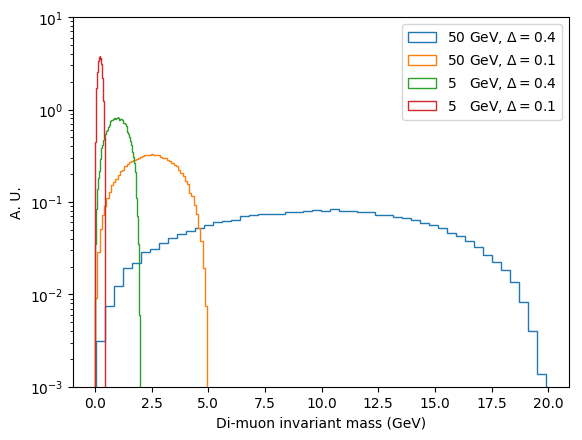

In [99]:
# M_A'^2 = (e1 + e2)^2 - (px1+px2)^2 + (py1+py2)^2 + (pz1+pz2)^2
# Or M_A'^2 = 2 * pT1 * pT2 * (cosh(eta1 - eta2) - cos(phi1 - phi2))

for mchi in mchis:
    reducedDf = genNewDfs[mchi][10].query('subentry==5|subentry==6')[['pt','eta','phi']]
    idx = pd.IndexSlice

    invMass = np.sqrt(2 * reducedDf.loc[idx[:,5], 'pt'].reset_index(level=1).drop(columns='subentry')['pt'] * \
    reducedDf.loc[idx[:,6], 'pt'].reset_index(level=1).drop(columns='subentry')['pt'] * \
    (np.cosh(reducedDf.loc[idx[:,5], 'eta'].reset_index(level=1).drop(columns='subentry')['eta'] - \
            reducedDf.loc[idx[:,6], 'eta'].reset_index(level=1).drop(columns='subentry')['eta']) - \
    np.cos(reducedDf.loc[idx[:,5], 'phi'].reset_index(level=1).drop(columns='subentry')['phi'] - \
            reducedDf.loc[idx[:,6], 'phi'].reset_index(level=1).drop(columns='subentry')['phi'])))

    plt.hist(invMass, bins=50, density=True, histtype='step', log=True, label=labels[mchi]);

plt.ylim([0.001, 10])
plt.xlabel('Di-muon invariant mass (GeV)')
plt.ylabel('A. U.')
plt.legend(loc='upper right');

## Test stuff

In [84]:
test=pd.concat([abs(2*math.pi - abs(reducedGenDf['phi']['mu1']) - abs(reducedGenDf['phi','mu2'])), \
        abs(reducedGenDf['phi']['mu1'] - reducedGenDf['phi']['mu2'])], axis=1)
test2=pd.concat([test, reducedGenDf], axis=1)
# test2[('phi','mu2')]
# test2['avg'] = test2[ test2[0] > test2[1] ][('phi','mu1')]/2 + test2[ test2[0] > test2[1] ][('phi','mu2')]/2
# test2['avg2'] = test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]>test2[('phi','mu2')]) ][('phi','mu1')] + \
#                 test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]>test2[('phi','mu2')]) ][0]/2
# test2['avg2'] = test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]<test2[('phi','mu2')]) ][('phi','mu2')] + \
#                 test2[ (test2[0] < test2[1]) & (test2[('phi','mu1')]<test2[('phi','mu2')]) ][0]/2
# test2['avg3'] = test2[ (test2[0] < test2[1]) & (test2['avg2']>math.pi) ]['avg2'] - 2*math.pi
test2['avg0'] = test2[('phi','mu1')]/2 + test2[('phi','mu2')]/2
test2['avg1'] = test2[('phi','mu1')] + test2[0]/2
test2['avg1.5'] = test2[('phi','mu2')] + test2[0]/2

def f(row):
    if row[0] > row[1]:
        return row['avg0']
    if row[('phi','mu1')] > row[('phi','mu2')]:
        if row['avg1'] > math.pi:
            return row['avg1'] - 2*math.pi
        return row['avg1']
    if row['avg1.5'] > math.pi:
        return row['avg1.5'] - 2*math.pi
    return row['avg1.5']

test2['final'] = test2.apply(f, axis=1)